In [1]:
import os
import re
import time
from pathlib import Path
import shutil
import glob
import string
import unicodedata
from datetime import datetime, timedelta

import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.select import Select
from sqlalchemy import create_engine
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from unicodedata import normalize, category

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stopset = set(stopwords.words("spanish"))
print(stopset)

{'tu', 'estando', 'sintiendo', 'estaría', 'yo', 'tenemos', 'estaremos', 'has', 'quien', 'tus', 'tengo', 'habido', 'esté', 'hay', 'nuestro', 'hayas', 'tengamos', 'fuerais', 'tuyos', 'tuviese', 'antes', 'hubiese', 'una', 'ya', 'esa', 'o', 'mucho', 'fuéramos', 'éramos', 'hubiera', 'tienes', 'con', 'les', 'fuimos', 'fuésemos', 'ellos', 'hayamos', 'es', 'haya', 'tuvo', 'habiendo', 'seremos', 'esto', 'estado', 'está', 'esas', 'estabais', 'estará', 'fuera', 'estés', 'estuvieseis', 'tendríamos', 'estuviesen', 'entre', 'algunos', 'hayan', 'estuvieron', 'sentido', 'nuestra', 'tenida', 'estuviera', 'habría', 'tenía', 'fuese', 'no', 'hasta', 'otras', 'tuviésemos', 'que', 'será', 'algo', 'tendremos', 'el', 'quienes', 'tenido', 'hube', 'habremos', 'hubiste', 'nosotros', 'del', 'tuya', 'se', 'como', 'en', 'mí', 'he', 'mías', 'hubierais', 'era', 'fueran', 'tendrán', 'tuvieran', 'estadas', 'unos', 'hubieran', 'míos', 'tuviesen', 'eran', 'tendrá', 'ha', 'estarás', 'nuestros', 'los', 'tened', 'hubimos', 

In [3]:
tweets = pd.read_excel('trinoscerveza.xlsx')
print(tweets.shape)
tweets.head()

(200, 91)


,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,text2
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,"@intensaaa2020 Mmm ya me fastidie, no me gusta...",Twitter for Android,68,1.419892e+18,1.337034e+18,intensaaa2020,...,1856,2010-09-05 05:30:41,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/18707734...,http://abs.twimg.com/images/themes/theme18/bg.gif,http://pbs.twimg.com/profile_images/8402706560...,"@intensaaa2020 Mmm ya me fastidie, no me gusta..."
1,754923173422833665,1420117600227536899,2021-07-27 20:23:15,susiurbizu,No saben lo mucho que quisiera que me gustara ...,Twitter for iPhone,70,NaN,NaN,NaN,...,4451,2016-07-18 06:18:05,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/75492317...,NaN,http://pbs.twimg.com/profile_images/1392738046...,No saben lo mucho que quisiera que me gustara ...
2,4518941727,1420117528110587905,2021-07-27 20:22:57,Veothfolnir,Escribo mal porque he bebido medio litro de ce...,TweetDeck,100,NaN,NaN,NaN,...,25370,2015-12-18 00:02:33,False,https://t.co/0pxjj8LIZr,https://www.youtube.com/channel/UCRsjWfA-Z4veF...,NaN,https://pbs.twimg.com/profile_banners/45189417...,NaN,http://pbs.twimg.com/profile_images/1340260811...,Escribo mal porque he bebido medio litro de ce...
3,1284180586257670147,1420117527384965121,2021-07-27 20:22:57,tu_tio_teviola,"@marlasuarezzz Cerveza, Vino, Whisky, Helado j...",Twitter for Android,42,1.420092e+18,1.282937e+18,marlasuarezzz,...,18904,2020-07-17 17:38:24,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12841805...,NaN,http://pbs.twimg.com/profile_images/1417326584...,"@marlasuarezzz Cerveza, Vino, Whisky, Helado j..."
4,1338605739221413888,1420117511786442752,2021-07-27 20:22:53,topdescuentostg,"💥Taza de Café, 18oz Vaso Termico Café Termo Do...",FRIKItwitter,260,NaN,NaN,NaN,...,0,2020-12-14 22:04:48,False,https://t.co/ks5VRb7KD1,https://t.me/TOP_Descuentos,NaN,https://pbs.twimg.com/profile_banners/13386057...,NaN,http://pbs.twimg.com/profile_images/1338609798...,"💥Taza de Café, 18oz Vaso Termico Café Termo Do..."


In [4]:
#tweets = pd.read_csv('ejercicio_tuits.csv', encoding='ISO-8859-1')

#if 'Unnamed: 0' in tweets.columns:
#    del tweets['Unnamed: 0']
    
#tweets['created_date'] = pd.to_datetime(tweets['created'])
#tweets['periodo'] = tweets['created_date'].apply(lambda x: x.strftime('%Y%m'))
#tweets['n_words'] = tweets['text'].apply(lambda _: len(_.split()))

#tweets.head(50)

### NULOS

In [5]:
tweets.isnull().sum()

user_id                     0
status_id                   0
created_at                  0
screen_name                 0
text                        0
                         ... 
account_lang              200
profile_banner_url         23
profile_background_url     94
profile_image_url           0
text2                       0
Length: 91, dtype: int64

### LIMPIANDO STOPWORDS POR DEFECTO

In [6]:
from unicodedata import normalize, category

def clean_text_1(_text):
    """
        Ll : minusculas
        Zs : espacios
        Lu : mayusculas
        Nd : numeros
        Mn : tildes
        Ps : abre dieresis, .....
        Pe : cierra dieresis, .......
        Pi : abre parentesis, .....
        Po : cierra parentesis, punto, coma, .....        
        ...
    """
    selects_characters = ['Ll', 'Zs', 'Lu']
    
    return ''.join([_.lower() for _ in normalize('NFD', _text.replace(' ', 'ZZZ')) if category(_) in selects_characters])

stopset_cleaned = [clean_text_1(word) for word in stopset]
print(stopset_cleaned)

['tu', 'estando', 'sintiendo', 'estaria', 'yo', 'tenemos', 'estaremos', 'has', 'quien', 'tus', 'tengo', 'habido', 'este', 'hay', 'nuestro', 'hayas', 'tengamos', 'fuerais', 'tuyos', 'tuviese', 'antes', 'hubiese', 'una', 'ya', 'esa', 'o', 'mucho', 'fueramos', 'eramos', 'hubiera', 'tienes', 'con', 'les', 'fuimos', 'fuesemos', 'ellos', 'hayamos', 'es', 'haya', 'tuvo', 'habiendo', 'seremos', 'esto', 'estado', 'esta', 'esas', 'estabais', 'estara', 'fuera', 'estes', 'estuvieseis', 'tendriamos', 'estuviesen', 'entre', 'algunos', 'hayan', 'estuvieron', 'sentido', 'nuestra', 'tenida', 'estuviera', 'habria', 'tenia', 'fuese', 'no', 'hasta', 'otras', 'tuviesemos', 'que', 'sera', 'algo', 'tendremos', 'el', 'quienes', 'tenido', 'hube', 'habremos', 'hubiste', 'nosotros', 'del', 'tuya', 'se', 'como', 'en', 'mi', 'he', 'mias', 'hubierais', 'era', 'fueran', 'tendran', 'tuvieran', 'estadas', 'unos', 'hubieran', 'mios', 'tuviesen', 'eran', 'tendra', 'ha', 'estaras', 'nuestros', 'los', 'tened', 'hubimos', 

### LIMPIANDO TWEETS

In [7]:
#!pip install spacy                                  -- descomentar la 1era vez

In [8]:
#!pip install stanza                                 -- descomentar la 1era vez

In [9]:
#!pip install "spacy-stanza<0.3.0" --user            -- descomentar la 1era vez

In [10]:
import stanza

In [11]:
#stanza.download('es')                                -- descomentar la 1era vez

In [12]:
from spacy_stanza import StanzaLanguage

In [13]:
snlp = stanza.Pipeline(lang="es")
nlp = StanzaLanguage(snlp)

2021-11-05 19:42:29 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-11-05 19:42:29 INFO: Use device: cpu
2021-11-05 19:42:29 INFO: Loading: tokenize
2021-11-05 19:42:29 INFO: Loading: mwt
2021-11-05 19:42:29 INFO: Loading: pos
2021-11-05 19:42:31 INFO: Loading: lemma
2021-11-05 19:42:31 INFO: Loading: depparse
2021-11-05 19:42:31 INFO: Loading: ner
2021-11-05 19:42:32 INFO: Done loading processors!


#### Ampliando STOPWORDS

In [14]:
print(len(stopset_cleaned))
stopset_cleaned = stopset_cleaned + ['caption', 'image']
print(len(stopset_cleaned))

313
315


### LEMMATIZACION QUITANDO STOP WORDS

In [15]:
%%time

import emot
import swifter

text = ':-) Woohooo😍✌️'

def clean_mean(val):
    return val.replace('_', ' ').replace('-', ' ').replace(':', ' ') + ' '

def handle_emoji_emoti(text):
    for emoti in emot.emo_unicode.EMOTICONS:
        if emoti in text:
            text = text.replace(emoti, ' ' + clean_mean(emot.emo_unicode.EMOTICONS.get(emoti, '')))
            print(emoti, end=' ')

    for emoti in emot.emo_unicode.UNICODE_EMO:
        if emoti in text:
            text = text.replace(emoti, ' ' + clean_mean(emot.emo_unicode.UNICODE_EMO.get(emoti, '')))
            print(emoti, end=' ')

    for emoti in emot.emo_unicode.EMOTICONS_EMO:
        if emoti in text:
            text = text.replace(emoti, ' ' + clean_mean(emot.emo_unicode.EMOTICONS_EMO.get(emoti, '')))
            print(emoti, end=' ')
        
    return text
        

tweets['tweet_emot'] = tweets['text'].apply(handle_emoji_emoti)

💪 🏻 🤣 :/ 💥 ❌ 👁 🛒 ✅ :/ :/ :/ 😂 ❤ 😍 :/ :/ :/ 😝 🤣 😇 :/ 😲 🚔 d: :/ 🤠 :/ :/ 🍺 🐔 🍺 :/ 😂 🏀 :/ 😢 😯 😎 :/ XD ♀ 🏼 :/ 📺 d: 😂 :/ 👽 :/ 😩 :/ :/ :/ 📌 :/ ✅ :') 😌 😂 :/ ♀ 🏻 🤦 :/ 💨 😮 😫 :/ :/ 😅 😂 :/ :/ :/ 😂 ☺ 😆 :/ :( :/ :/ :/ 🎉 🙌 😍 😩 😜 😪 🤣 😆 😂 🤣 😎 :/ :/ :/ :/ :/ :/ 😭 💫 😵 😤 :/ 📩 ✔ 📦 :/ Wall time: 1.33 s


In [16]:
%%time

import functools

def clean_tweet(new):
    tokenizacion = [
        [
           ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence) 
                         if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
        ] for sentence in nltk.sent_tokenize(new)
    ]
    
    return " ".join(functools.reduce(lambda x ,y : x + y , tokenizacion))+" "

tweets['tweet_cleaned'] = tweets['tweet_emot'].apply(clean_tweet)

Wall time: 4min 15s


In [18]:
tweets.tail()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,text2,tweet_emot,tweet_cleaned
195,1145047622,1420109137275461642,2021-07-27 19:49:37,MrTrocolo,Ganas de tomarme 18L cerveza pero ninguna de m...,Twitter for iPhone,61,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/11450476...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1417061926...,Ganas de tomarme 18L cerveza pero ninguna de m...,Ganas de tomarme 18L cerveza pero ninguna de m...,gana tomaryo l cerveza ninguno moverme sofa
196,1346200940811055108,1420108906982952967,2021-07-27 19:48:42,dexdian_,@AUR0NBUH0 cerveza\n#KCAMexico #AuronPlay #Joa...,Twitter Web App,45,1.420106e+18,1.261208e+18,AUR0NBUH0,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/13462009...,NaN,http://pbs.twimg.com/profile_images/1415395399...,@AUR0NBUH0 cerveza\n#KCAMexico #AuronPlay #Joa...,@AUR0NBUH0 cerveza\n#KCAMexico #AuronPlay #Joa...,aurnbuh cerveza kcamexico auronplar joaquinbon...
197,60033096,1420108885206110212,2021-07-27 19:48:37,razanon,@yosoylalimon @senora_rubia Barda es un ejempl...,Twitter for Android,214,1.420108e+18,1.274265e+18,yosoylalimon,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/60033096...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1325819388...,@yosoylalimon @senora_rubia Barda es un ejempl...,@yosoylalimon @senora_rubia Barda es un ejempl...,yosoylalimon senorarubir barda ejemplo vacio c...
198,921522062816174080,1420108867053236225,2021-07-27 19:48:32,E_BPinki,si me vacune ayer puedo beber cerveza hoy??? d...,Twitter for iPhone,55,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/92152206...,NaN,http://pbs.twimg.com/profile_images/1400526715...,si me vacune ayer puedo beber cerveza hoy??? d...,si me vacune ayer puedo beber cerveza hoy??? d...,vacunir ayer poder beber cerveza hoy duda
199,1354941251771117579,1420108797071212547,2021-07-27 19:48:16,ARSXNISTLULLABY,ㅤ\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀❛ㅤAtrapala en la primera media h...,Twitter for Android,86,NaN,NaN,NaN,...,False,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/13549412...,NaN,http://pbs.twimg.com/profile_images/1419805725...,ㅤ\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀❛ㅤAtrapala en la primera media h...,ㅤ\n⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀❛ㅤAtrapala en la primera media h...,atrapala primero medio hora invitar mantequill...


In [19]:
tweets.to_csv('tweets_cleaned.csv', index=False)

<AxesSubplot:>

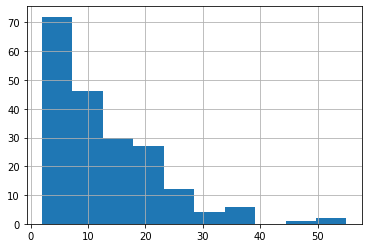

In [20]:
tweets['n_words_cleaned'] = tweets['tweet_cleaned'].apply(lambda _: len(_.split()))
tweets['n_words_cleaned'].hist()

In [21]:
tweets.iloc[:,-10:].head()

,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,text2,tweet_emot,tweet_cleaned,n_words_cleaned
0,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/18707734...,http://abs.twimg.com/images/themes/theme18/bg.gif,http://pbs.twimg.com/profile_images/8402706560...,"@intensaaa2020 Mmm ya me fastidie, no me gusta...","@intensaaa2020 Mmm ya me fastidie, no me gusta...",intensaar mmm fastidiar gustar beber casi dw a...,9
1,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/75492317...,NaN,http://pbs.twimg.com/profile_images/1392738046...,No saben lo mucho que quisiera que me gustara ...,No saben lo mucho que quisiera que me gustara ...,saber querer gustar cerveza nomas,5
2,https://t.co/0pxjj8LIZr,https://www.youtube.com/channel/UCRsjWfA-Z4veF...,NaN,https://pbs.twimg.com/profile_banners/45189417...,NaN,http://pbs.twimg.com/profile_images/1340260811...,Escribo mal porque he bebido medio litro de ce...,Escribo mal porque he bebido medio litro de ce...,escribir mal bebido medio litro cerveza ingest...,12
3,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/12841805...,NaN,http://pbs.twimg.com/profile_images/1417326584...,"@marlasuarezzz Cerveza, Vino, Whisky, Helado j...","@marlasuarezzz Cerveza, Vino, Whisky, Helado j...",marlasuarezzz cerveza venir whisky helado jeje...,16
4,https://t.co/ks5VRb7KD1,https://t.me/TOP_Descuentos,NaN,https://pbs.twimg.com/profile_banners/13386057...,NaN,http://pbs.twimg.com/profile_images/1338609798...,"💥Taza de Café, 18oz Vaso Termico Café Termo Do...","collision Taza de Café, 18oz Vaso Termico Ca...",collision taza cafe oz vaso termico cafe termo...,55


In [22]:
tweets.shape

(200, 94)

### TOKENS

In [28]:
tweets['texto_tokenizado'] = tweets['tweet_cleaned'].apply(lambda _: _.split())
tweets.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,text2,tweet_emot,tweet_cleaned,n_words_cleaned,texto_tokenizado
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,"@intensaaa2020 Mmm ya me fastidie, no me gusta...",Twitter for Android,68,1.419892e+18,1.337034e+18,intensaaa2020,...,NaN,NaN,https://pbs.twimg.com/profile_banners/18707734...,http://abs.twimg.com/images/themes/theme18/bg.gif,http://pbs.twimg.com/profile_images/8402706560...,"@intensaaa2020 Mmm ya me fastidie, no me gusta...","@intensaaa2020 Mmm ya me fastidie, no me gusta...",intensaar mmm fastidiar gustar beber casi dw a...,9,"[intensaar, mmm, fastidiar, gustar, beber, cas..."
1,754923173422833665,1420117600227536899,2021-07-27 20:23:15,susiurbizu,No saben lo mucho que quisiera que me gustara ...,Twitter for iPhone,70,NaN,NaN,NaN,...,NaN,NaN,https://pbs.twimg.com/profile_banners/75492317...,NaN,http://pbs.twimg.com/profile_images/1392738046...,No saben lo mucho que quisiera que me gustara ...,No saben lo mucho que quisiera que me gustara ...,saber querer gustar cerveza nomas,5,"[saber, querer, gustar, cerveza, nomas]"
2,4518941727,1420117528110587905,2021-07-27 20:22:57,Veothfolnir,Escribo mal porque he bebido medio litro de ce...,TweetDeck,100,NaN,NaN,NaN,...,https://www.youtube.com/channel/UCRsjWfA-Z4veF...,NaN,https://pbs.twimg.com/profile_banners/45189417...,NaN,http://pbs.twimg.com/profile_images/1340260811...,Escribo mal porque he bebido medio litro de ce...,Escribo mal porque he bebido medio litro de ce...,escribir mal bebido medio litro cerveza ingest...,12,"[escribir, mal, bebido, medio, litro, cerveza,..."
3,1284180586257670147,1420117527384965121,2021-07-27 20:22:57,tu_tio_teviola,"@marlasuarezzz Cerveza, Vino, Whisky, Helado j...",Twitter for Android,42,1.420092e+18,1.282937e+18,marlasuarezzz,...,NaN,NaN,https://pbs.twimg.com/profile_banners/12841805...,NaN,http://pbs.twimg.com/profile_images/1417326584...,"@marlasuarezzz Cerveza, Vino, Whisky, Helado j...","@marlasuarezzz Cerveza, Vino, Whisky, Helado j...",marlasuarezzz cerveza venir whisky helado jeje...,16,"[marlasuarezzz, cerveza, venir, whisky, helado..."
4,1338605739221413888,1420117511786442752,2021-07-27 20:22:53,topdescuentostg,"💥Taza de Café, 18oz Vaso Termico Café Termo Do...",FRIKItwitter,260,NaN,NaN,NaN,...,https://t.me/TOP_Descuentos,NaN,https://pbs.twimg.com/profile_banners/13386057...,NaN,http://pbs.twimg.com/profile_images/1338609798...,"💥Taza de Café, 18oz Vaso Termico Café Termo Do...","collision Taza de Café, 18oz Vaso Termico Ca...",collision taza cafe oz vaso termico cafe termo...,55,"[collision, taza, cafe, oz, vaso, termico, caf..."


In [29]:
tweets_tidy = tweets[['user_id', 'status_id', 'created_at', 'screen_name', 'tweet_cleaned', 'texto_tokenizado']].explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='tweet_cleaned')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head()

,user_id,status_id,created_at,screen_name,token
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,intensaar
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,mmm
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,fastidiar
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,gustar
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,beber


In [30]:
tweets_tidy.shape, tweets.shape

((2604, 5), (200, 95))

In [32]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='screen_name')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


screen_name
0ffs3twl         18
118ari           24
1nteGral_Rice    10
80DREWALLS        9
ADNJMx           15
                 ..
victor_jrp       28
workerfemme      18
ydnation_         9
yuprad0           7
zucepunk         47
Name: token, Length: 198, dtype: int64

In [33]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='screen_name')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


screen_name
0ffs3twl         17
118ari           23
1nteGral_Rice    10
80DREWALLS        9
ADNJMx           15
                 ..
victor_jrp       28
workerfemme      17
ydnation_         8
yuprad0           7
zucepunk         17
Name: token, Length: 198, dtype: int64

In [35]:
print(tweets_tidy.shape)
tweets_tidy = tweets_tidy[tweets_tidy['token'] != 'https']
print(tweets_tidy.shape)

(2604, 5)
(2561, 5)


In [36]:
tweets_tidy.groupby(['screen_name','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('screen_name') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

screen_name               token  count
screen_name                                            
0ffs3twl    3       0ffs3twl             cerveza      2
            0       0ffs3twl             annoyed      1
            1       0ffs3twl               beber      1
            2       0ffs3twl                casi      1
            4       0ffs3twl  hesitanttcozdekctl      1
...                      ...                 ...    ...
zucepunk    2326    zucepunk                 joy      7
            2322    zucepunk                face      7
            2330    zucepunk               tears      7
            2327    zucepunk                  of      7
            2334    zucepunk                with      7

[956 rows x 3 columns]

In [52]:
import numpy as np
tweets['autor'] = tweets['screen_name'].copy()

In [44]:
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

In [40]:
import gc
gc.collect()

374

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [42]:
import gc
gc.collect()

44

In [53]:
tweets[['user_id', 'status_id', 'created_at', 'screen_name', 'tweet_cleaned', 'texto_tokenizado']].head()

,user_id,status_id,created_at,screen_name,tweet_cleaned,texto_tokenizado
0,187077341,1420117682163228672,2021-07-27 20:23:34,Seahawk_Davo,intensaar mmm fastidiar gustar beber casi dw a...,"[intensaar, mmm, fastidiar, gustar, beber, cas..."
1,754923173422833665,1420117600227536899,2021-07-27 20:23:15,susiurbizu,saber querer gustar cerveza nomas,"[saber, querer, gustar, cerveza, nomas]"
2,4518941727,1420117528110587905,2021-07-27 20:22:57,Veothfolnir,escribir mal bebido medio litro cerveza ingest...,"[escribir, mal, bebido, medio, litro, cerveza,..."
3,1284180586257670147,1420117527384965121,2021-07-27 20:22:57,tu_tio_teviola,marlasuarezzz cerveza venir whisky helado jeje...,"[marlasuarezzz, cerveza, venir, whisky, helado..."
4,1338605739221413888,1420117511786442752,2021-07-27 20:22:53,topdescuentostg,collision taza cafe oz vaso termico cafe termo...,"[collision, taza, cafe, oz, vaso, termico, caf..."


In [48]:
gc.collect()

189

In [49]:
print(len(stopset_cleaned))
stopset_cleaned = stopset_cleaned + ['https']
print(len(stopset_cleaned))

315
316


In [54]:
datos_X = tweets['tweet_cleaned']
datos_y = tweets['autor']

In [56]:
datos_X.shape

(200,)

In [57]:
datos_y.value_counts(normalize=True)

StremsCarlos      0.010
leitag            0.010
lnadmor           0.005
ruff0_            0.005
JulianRojas_B     0.005
                  ...  
Soylupianez       0.005
LuisDementia      0.005
ruizchristiang    0.005
OctaviaMaigler    0.005
YermanyG          0.005
Name: autor, Length: 198, dtype: float64

In [58]:
SEED = 29082013
import random as rn

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [59]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = SEED
    
)

In [60]:
def clean_tweet_list(new):
    tokenizacion = [
        [
           ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence) 
                         if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
        ] for sentence in nltk.sent_tokenize(new)
    ]
    
    return list(functools.reduce(lambda x , y : x + y , tokenizacion))

In [61]:
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = clean_tweet_list,
                        min_df     = 0.01,
                        max_df     = 0.9,
                        stop_words = stopset_cleaned
                    )
tfidf_vectorizador.fit(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_df=0.9, min_df=0.01,
                stop_words=['tu', 'estando', 'sintiendo', 'estaria', 'yo',
                            'tenemos', 'estaremos', 'has', 'quien', 'tus',
                            'tengo', 'habido', 'este', 'hay', 'nuestro',
                            'hayas', 'tengamos', 'fuerais', 'tuyos', 'tuviese',
                            'antes', 'hubiese', 'una', 'ya', 'esa', 'o',
                            'mucho', 'fueramos', 'eramos', 'hubiera', ...],
                tokenizer=<function clean_tweet_list at 0x000001CCE2AE5EE0>)

In [62]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

In [63]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 209
['abrir', 'abuelo', 'acabar', 'acuerdo', 'agua', 'aguantar', 'ahi', 'ahora', 'alcohol', 'alcoholico']


### MODELAMIENTO

In [ ]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "linear")
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

In [ ]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {
    'C': np.logspace(-5, 3, 50),
    'shrinking': [True, False],
    'probability': [True, False],
    'class_weight': ['balanced', None]
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

In [ ]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

In [ ]:
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")

print("-------------------")

pd.DataFrame(
    confusion_matrix(
        y_true = y_test, 
        y_pred= predicciones_test
    ),
    columns= autores,
    index = autores
).style.background_gradient(axis=0)

In [ ]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "sigmoid")
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

In [ ]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {
    'C': np.logspace(-5, 3, 50),
    'shrinking': [True, False],
    'probability': [True, False],
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto']
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "sigmoid"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

In [ ]:
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")

print("-------------------")

pd.DataFrame(
    confusion_matrix(
        y_true = y_test, 
        y_pred= predicciones_test
    ),
    columns= autores,
    index = autores
).style.background_gradient(axis=0)

In [ ]:
# Entrenamiento del modelo SVM
# ==============================================================================
modelo_svm_lineal = svm.SVC(kernel= "poly")
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

In [ ]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {
    'C': np.logspace(-5, 3, 50),
    'shrinking': [True, False],
    'probability': [True, False],
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3, 4]
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "poly"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head(10)

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

In [ ]:
predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")

print("-------------------")

pd.DataFrame(
    confusion_matrix(
        y_true = y_test, 
        y_pred= predicciones_test
    ),
    columns= autores,
    index = autores
).style.background_gradient(axis=0)